
# Capstone Project
## Data Scientist Nanodegree
Eduardo Paredes\
January 12, 2023


# Analysis steps that you should take when forecasting with Linear Regression and Random Forest
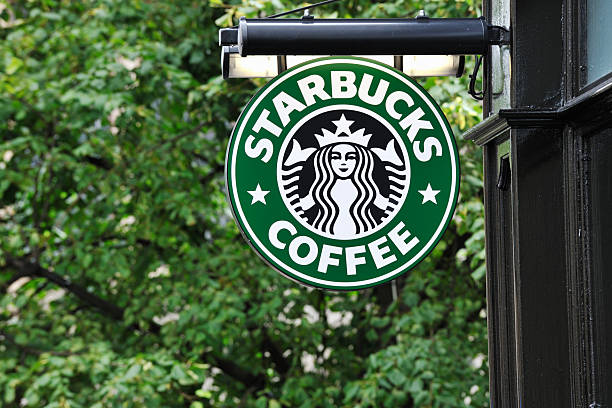

## Section 1: Project Definition
### Project Overview
Two supervised models, Random Forest and Linear Regression, were used to forecast the amount spent by the Starbucks user using as factors demographic characteristics and offer type. Then, a comparison was made to analyze the results

### Problem Statement
Forecasting is crucial for many businesses; however, when it came to choosing a prediction model, the trade-off between accuracy, complexity, and time appears.

Well-known is the Linear Regression as Random Forest; however, the first one is the base of statistical models. Also, it needs to obey some assumptions, while the second is more direct and -most of the time- more accurate (depending on solving the overfitting) but time-consuming due to complex algorithms. Therefore, it is worth analyzing and comparing the results of both models.

Using a mimic data set of Starbucks users, the questions of interest are the following:

I) What is the procedure analysis when forecasting using Linear Regression Model?

II) What is the procedure analysis when forecasting using Random Forest Model?

III) What differences can be found in the results between Linear Regression and Random Forest?

### Metrics
Due to the fact of the use of regression models, the basic metrics to apply are Mean Absolute Error, Mean Squared Error, Square Root Mean Squared Error. Also some aditional tests will be applied to check the assumptions of the Linear Regression model.


## Section 2: Analysis

### Data Exploration

In [52]:
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
from datetime import datetime, timedelta

import random

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)



In [53]:
# How many offer types are?
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [54]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [55]:
portfolio[['difficulty', 'duration', 'reward', 'offer_type']].value_counts()

difficulty  duration  reward  offer_type   
0           3         0       informational    1
            4         0       informational    1
5           5         5       bogo             1
            7         5       bogo             1
7           7         3       discount         1
10          5         10      bogo             1
            7         2       discount         1
                      10      bogo             1
            10        2       discount         1
20          10        5       discount         1
dtype: int64

The offer types varies in difficulty variation, duration and reward. There are bogo, discount and informational. 

In [56]:
# What are the variables contain in profile data? (the characteristics of each user)
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [57]:
# How is presented the var became_member_on?
profile.became_member_on.head(10)

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
5    20180426
6    20170925
7    20171002
8    20180209
9    20161122
Name: became_member_on, dtype: int64

It has the date of the start of the membership in integers. It must be cleaned

In [58]:
# What genders are included?
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [59]:
# What variables are included in transcript? How are they presented?
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [60]:
# How many events are?
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The case explains that the offers will be counted only if the offer is completed, which has the same time as the transaction. It means that each offer completed has a transaction event at the same time, which becomes a unit of analysis. Therefore, in this study, the offers completed will only be taken into account

In [61]:
transcript[transcript.person == '94de646f7b6041228ca7dec82adb97d2'][['value', 'time', 'event']].head(10)

,value,time,event
2276,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,offer received
16010,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6,offer viewed
24531,{'amount': 7.41},30,transaction
24532,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,30,offer completed
42252,{'amount': 1.47},102,transaction
55475,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},168,offer received
75256,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},186,offer viewed
77624,{'amount': 2.62},192,transaction
81725,{'amount': 0.59},204,transaction
93913,{'amount': 2.2800000000000002},246,transaction


For example, this person received and have and completed an offer at time 30 and paid an amount of 7.41 dollars.
The variable 'value' has dictionaries in each observation; it will be cleaned to have the amount and the offer id in the same row

In [62]:
# Cleaning value var
transcript['value_keys'] = transcript.value.apply(lambda x: list(x.items())[0][0])

#extract values
transcript['value_values'] = transcript.value.apply(lambda x: list(x.items())[0][1])

#convert to numeric to extract the values
transcript['amount'] = pd.to_numeric(transcript.value_values, errors='coerce')

### Data Visualization

<AxesSubplot:xlabel='income', ylabel='Count'>

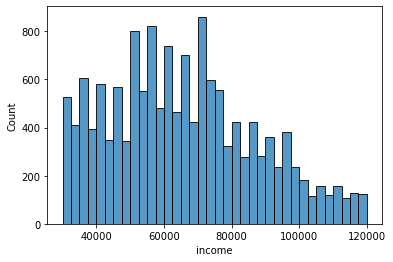

In [63]:
# What is the distribution of the income?
sns.histplot(profile.income)

<AxesSubplot:xlabel='amount', ylabel='Count'>

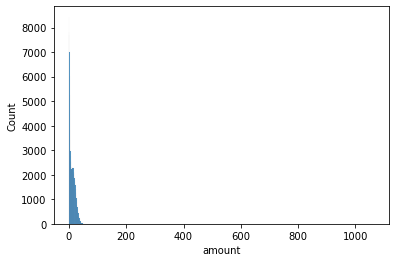

In [64]:
# What is the distribution of the amount spent?
sns.histplot(transcript.amount)

The variable amount spent has a lot of outliers. They must be removed in order to have a better prediction

<AxesSubplot:xlabel='amount', ylabel='Count'>

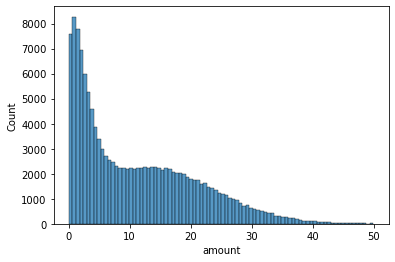

In [65]:
sns.histplot(transcript.amount[transcript.amount < 50])

In the next steps, interquartile range will be used to clearly identify and remove the outliers

## Section 3: Methodology

### Data preprocessing


In [66]:
# Merging data
# separate the amount and offer id an then merge them by person and time
temp1 = transcript[transcript.value_keys == 'amount']
temp2 = transcript[transcript.value_keys == 'offer_id']

temp1.columns
temp1 = temp1[['person', 'time', 'value_values']]
temp1.columns = ['person', 'time', 'amount']

temp2 = temp2[['person', 'time', 'value_values', 'event']]
temp2.columns = ['person', 'time', 'offer_id', 'event']

#merge by person and time
df = temp1.merge(temp2, how = 'inner', on = ['person', 'time'])

#merge df with profile
profile.columns =['gender', 'age', 'person', 'became_member_on', 'income']

df = df.merge(profile, how = 'inner', on = ['person'])

#merge df with portfolio on offer_id
portfolio.columns = ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'offer_id']
df = df.merge(portfolio, how = 'inner', on = ['offer_id'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            33579 non-null  object 
 1   time              33579 non-null  int64  
 2   amount            33579 non-null  object 
 3   offer_id          33579 non-null  object 
 4   event             33579 non-null  object 
 5   gender            32444 non-null  object 
 6   age               33579 non-null  int64  
 7   became_member_on  33579 non-null  int64  
 8   income            32444 non-null  float64
 9   reward            33579 non-null  int64  
 10  channels          33579 non-null  object 
 11  difficulty        33579 non-null  int64  
 12  duration          33579 non-null  int64  
 13  offer_type        33579 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 3.8+ MB


In [67]:
#Drop the rows where the amount has missing values
df  = df.dropna(subset=['amount'], axis=0)
df.amount = df.amount.astype(float)

In [68]:
#Drop the columns that are identifiers
df = df.drop(['person', 'time', 'offer_id', 'event'], axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            33579 non-null  float64
 1   gender            32444 non-null  object 
 2   age               33579 non-null  int64  
 3   became_member_on  33579 non-null  int64  
 4   income            32444 non-null  float64
 5   reward            33579 non-null  int64  
 6   channels          33579 non-null  object 
 7   difficulty        33579 non-null  int64  
 8   duration          33579 non-null  int64  
 9   offer_type        33579 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 2.8+ MB


In [69]:
#clean channel var
df.channels.value_counts()

for i in df.index:
    if df.channels.loc[i] == ['email', 'mobile', 'social']:
        df.channels.at[i] = [np.nan, 'email', 'mobile', 'social'] 
    
temp = pd.DataFrame(df['channels'].tolist(), index=df.index)

temp[2].value_counts() # test! there must be just mobile option with 30159 obs

mobile    30159
Name: 2, dtype: int64

In [70]:
# Transform channel var to dummies
temp['web'] = np.where(temp[0] == 'web', 1, 0) #transform to dummies variables
temp['email'] = np.where(temp[1] == 'email', 1, 0)
temp['mobile'] = np.where(temp[2] == 'mobile', 1, 0)
temp['social'] = np.where(temp[3] == 'social', 1, 0)

temp.web.value_counts()

1    29891
0     3688
Name: web, dtype: int64

In [71]:
temp.email.value_counts() #email does not have variability, it will be dropped

1    33579
Name: email, dtype: int64

In [72]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       29891 non-null  object
 1   1       33579 non-null  object
 2   2       30159 non-null  object
 3   3       21788 non-null  object
 4   web     33579 non-null  int32 
 5   email   33579 non-null  int32 
 6   mobile  33579 non-null  int32 
 7   social  33579 non-null  int32 
dtypes: int32(4), object(4)
memory usage: 2.8+ MB


In [73]:
#merge temp with df
temp = temp.drop([0, 1 , 2 , 3, 'email'], axis = 1) 

df = pd.concat([df, temp], axis = 1) 
df.info()
df = df.drop(['channels'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            33579 non-null  float64
 1   gender            32444 non-null  object 
 2   age               33579 non-null  int64  
 3   became_member_on  33579 non-null  int64  
 4   income            32444 non-null  float64
 5   reward            33579 non-null  int64  
 6   channels          33579 non-null  object 
 7   difficulty        33579 non-null  int64  
 8   duration          33579 non-null  int64  
 9   offer_type        33579 non-null  object 
 10  web               33579 non-null  int32  
 11  mobile            33579 non-null  int32  
 12  social            33579 non-null  int32  
dtypes: float64(2), int32(3), int64(5), object(3)
memory usage: 4.2+ MB


In [74]:
#clean became member and then drop
df['timeMember'] = pd.to_datetime(df.became_member_on.astype(str), format='%Y%m%d')
limit_time = df['timeMember'].max()

df['timeMember'] = limit_time - df.timeMember
df['timeMember'] = df.timeMember.dt.days

df = df.drop(['became_member_on'], axis= 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amount      33579 non-null  float64
 1   gender      32444 non-null  object 
 2   age         33579 non-null  int64  
 3   income      32444 non-null  float64
 4   reward      33579 non-null  int64  
 5   difficulty  33579 non-null  int64  
 6   duration    33579 non-null  int64  
 7   offer_type  33579 non-null  object 
 8   web         33579 non-null  int32  
 9   mobile      33579 non-null  int32  
 10  social      33579 non-null  int32  
 11  timeMember  33579 non-null  int64  
dtypes: float64(2), int32(3), int64(5), object(2)
memory usage: 4.0+ MB


Became_member_on variable has been changed to timeMember which correspond to the number of days of being a member since the last user membership

In [75]:
#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_df.columns
cat_df
cat_cols_lst = cat_df.columns

In [76]:
#Convert variables to dummies
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False) #Use your newly created function

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 0 to 33578
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   amount               33579 non-null  float64
 1   age                  33579 non-null  int64  
 2   income               32444 non-null  float64
 3   reward               33579 non-null  int64  
 4   difficulty           33579 non-null  int64  
 5   duration             33579 non-null  int64  
 6   web                  33579 non-null  int32  
 7   mobile               33579 non-null  int32  
 8   social               33579 non-null  int32  
 9   timeMember           33579 non-null  int64  
 10  gender_M             33579 non-null  uint8  
 11  gender_O             33579 non-null  uint8  
 12  offer_type_discount  33579 non-null  uint8  
dtypes: float64(2), int32(3), int64(5), uint8(3)
memory usage: 3.5 MB


In [77]:
#Missing values
df_new[df_new.income.isnull()].shape[0]/df_new.shape[0]*100 #3.4% has income null. Is relatively low the case, so the rows null will be deleted
df_new = df_new.dropna(axis = 0)

In [78]:
#Duplicated
df_new.duplicated().sum()
df_new=df_new[~df_new.duplicated()]

In [79]:
#Save as pickle (Checkpoint)
df_new.to_pickle("df_clean.pkl")

In [80]:
#Read df_clean
df = pd.read_pickle('df_clean.pkl')

In [81]:
#Import some libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [82]:
#identify outliers and remove from dataframe
q1 = np.percentile(df.amount, 25)
q3 = np.percentile(df.amount, 75)
iqr = q3-q1
lower = q1-1.5*iqr
upper = q3+1.5*iqr

"The number of outliers are {diff}".format(diff = df.shape[0] - df[(df.amount<upper)&(df.amount>lower)].shape[0])

'The number of outliers are 552'

In [83]:
"They represent the {percen}% of the total of observations".format(percen = \
                                                                   round(((df.shape[0] - df[(df.amount<upper)&(df.amount>lower)].shape[0])/df.shape[0]*100), 2))

'They represent the 1.72% of the total of observations'

In this case, due to the fact that the amount of outliers are just 1.72% of the total cases, they will be removed

In [84]:
df = df[(df.amount<upper)&(df.amount>lower)]

Text(0.5, 1.0, 'Distribution of Money Spent')

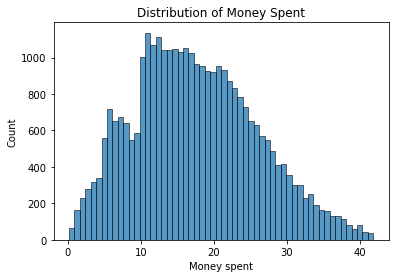

In [85]:
#Distibution of money spent
sns.histplot(df.amount)
plt.xlabel('Money spent')
plt.title('Distribution of Money Spent')

### Implementation

In this subchapter the Linear Regression Model wil be implemented with the following steps:
1. Spearmean correlation of the independent variables
2. VIF test to choose the independent variables
3. Check the normality assumption
3. Results


A way to know what variables will be chosen as factors of money spent is by analyzing the spearman correlation to detect a pair of variables with a high level of correlation because this case could lead to the problem of multicollinearity. Another point of view is to revise the literature on the phenomenon in the study. In this case, variables such as reward, difficulty, duration, and the types of channels of the offer can have a high correlation. Also, these variables can have a high relationship with the offer_type variable. Therefore, it could be better to just take offer_type as an independent variable added to the profile characteristics, rather than aggregate all the characteristics of the offers (reward, difficulty, duration, etc). However, taking more variables as factors can increase the R square; so, depending on the result of the analysis of multicollinearity the final model specification will be chosen.

In [86]:
#Spearman test
spearmanDF = pd.DataFrame(spearmanr(df[['reward', 'difficulty', 'duration', 'web',\
       'mobile', 'social', 'offer_type_discount']])[0])
spearmanDF.columns = ['reward', 'difficulty', 'duration', 'web', 'mobile', 'social', 'offer_type_discount']
spearmanDF.index = ['reward', 'difficulty', 'duration', 'web', 'mobile', 'social', 'offer_type_discount']
print(spearmanDF)

                       reward  difficulty  duration       web    mobile  \
reward               1.000000   -0.052552 -0.511674 -0.504402 -0.129655   
difficulty          -0.052552    1.000000  0.545443 -0.203267 -0.565103   
duration            -0.511674    0.545443  1.000000  0.019018 -0.474798   
web                 -0.504402   -0.203267  0.019018  1.000000 -0.119825   
mobile              -0.129655   -0.565103 -0.474798 -0.119825  1.000000   
social               0.142462   -0.124711 -0.272948 -0.262032  0.457292   
offer_type_discount -0.806625    0.468591  0.696119  0.376533 -0.318233   

                       social  offer_type_discount  
reward               0.142462            -0.806625  
difficulty          -0.124711             0.468591  
duration            -0.272948             0.696119  
web                 -0.262032             0.376533  
mobile               0.457292            -0.318233  
social               1.000000            -0.150620  
offer_type_discount -0.15062

The results show that there is not a high correlation between these variables (not higher than 0.8), but between reward and offer_type_discount (-0.81). The limit acepted is 0.8, so it surpassed the limit for a bit; it could be acepted, though. To test this problem Variance Inflation Factor would be taken into consideration.  

In [87]:
#Variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vifTest(factors):
    '''
    Variance Inflation test
    
    factors: array with the variable names of the independent variables
    output: Data Frame with the VIF results
    '''
    X = df[factors]

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    return vif_data

vifTest1 = vifTest(['age', 'income', 'reward', 'difficulty', 'duration', 'web',\
           'mobile', 'social', 'timeMember', 'gender_O', 'gender_M', 'offer_type_discount'])
print(vifTest1)

                feature        VIF
0                   age  13.139277
1                income  12.726129
2                reward  50.611347
3            difficulty  94.882677
4              duration  47.952881
5                   web  10.566569
6                mobile  38.706696
7                social   5.020839
8            timeMember   3.222211
9              gender_O   1.033763
10             gender_M   2.118672
11  offer_type_discount  24.811952


It is a problem of multicollinearity detected. VIF limit -rule of thumb- is 10; therefore, the 'difficulty' variable is generating a problem of multicollinearity and probably many other variables. It would be removed and taken again the VIF test

In [88]:
vifTest2 = vifTest(['age', 'income', 'reward', 'duration', 'web',\
           'mobile', 'social', 'timeMember', 'gender_O', 'gender_M', 'offer_type_discount'])
print(vifTest2)

                feature        VIF
0                   age  13.120885
1                income  12.690512
2                reward   9.079685
3              duration  25.150791
4                   web   9.439134
5                mobile  11.307257
6                social   4.316882
7            timeMember   3.221110
8              gender_O   1.033728
9              gender_M   2.118220
10  offer_type_discount   8.305973


The model continues having variables with a VIF higher than 10. Some more variables will be removed to avoid multicollinearity

In [89]:
vifTest3 = vifTest(['age', 'income', 'reward', 'web',\
           'social', 'timeMember', 'gender_O', 'gender_M', 'offer_type_discount'])
print(vifTest3)

               feature        VIF
0                  age  12.228406
1               income  11.952460
2               reward   6.711223
3                  web   8.028383
4               social   2.977050
5           timeMember   3.151131
6             gender_O   1.031668
7             gender_M   2.047110
8  offer_type_discount   3.766592


The 'age' and 'income' variables have a VIF higher than the limit; since those factors are crucial for the regression, they will not be deleted. However, as explained at the start of the subchapter, the characteristics of the offer_type will be removed and just the offer_type will be taken as a factor.

In [90]:
vifTest4 = vifTest(['age', 'income', 'timeMember', 'gender_O', 'gender_M', 'offer_type_discount'])
print(vifTest4)

               feature       VIF
0                  age  9.721170
1               income  9.361650
2           timeMember  2.976101
3             gender_O  1.026462
4             gender_M  1.891816
5  offer_type_discount  2.017574


Now, all variables have a VIF below 10; therefore, multicollinearity has been avoided. 

In [91]:
# Split the data 
Y = np.array(df['amount'])
X = np.array(df[['age', 'income', 'gender_M', 'gender_O', 'offer_type_discount']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

lm = LinearRegression()
lm.fit(X_train, Y_train)

#R square
rsq = lm.score(X_train, Y_train)

# Y train predictions
Y_hat = lm.predict(X_train)

#Y test predictions
lm_predictions = lm.predict(X_test)

Text(0.5, 1.0, 'Error Distribution')

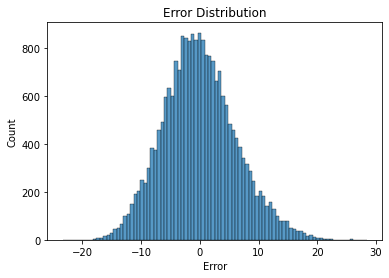

In [92]:
# Normality of the error
sns.histplot(Y_train - Y_hat)
plt.xlabel('Error')
plt.title('Error Distribution')

The model satifies the normality assumption of the error

Text(0, 0.5, 'lm_predictions')

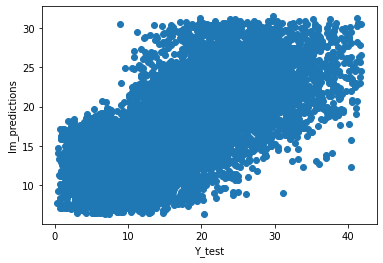

In [93]:
#Predictions of the test set
plt.scatter(x = Y_test, y = lm_predictions)
plt.xlabel('Y_test')
plt.ylabel('lm_predictions')

In [94]:
def metricsProject(Y, YPred):
    '''
    Function to calculate Absolute error, Mean Squared Error, Root Squared Error
    Input :
        - Y_test
        - Predictions = outcome of prediciting with the X_test set
    Output:
        - The metrics: Absolute error, Mean Squared Error, Root Squared Error
    Input
    '''

    return 'Absolute error: {abError}. \
    Mean Squared Error: {meanSqError}. \
    Root Squared Error: {RootSqError}'.format(abError = metrics.mean_absolute_error(Y, YPred),
                                                meanSqError = metrics.mean_squared_error(Y, YPred),
                                                RootSqError = np.sqrt(metrics.mean_squared_error(Y, YPred)))

In [95]:
#Metrics of the Y_train data set
metricsProject(Y_train, Y_hat)

'Absolute error: 4.923905231632085.     Mean Squared Error: 38.75139418984689.     Root Squared Error: 6.225061782010432'

In [96]:
#Metrics of the Y_test data set
metricsProject(Y_test, lm_predictions)

'Absolute error: 4.911328712901499.     Mean Squared Error: 38.65832155840111.     Root Squared Error: 6.217581648712071'

In [97]:
'R Squared is {rsq}'.format(rsq=rsq)

'R Squared is 0.44919257683357583'

The metrics of Y_train and Y_test are very similar: The model is not overfitting. On the other hand, a machine learning now will be tested in order to compare results. The same variables will be taken into account to have a better comparison. 

### Refinement

In this subchapter the Random Forest Model wil be implemented with the following steps:
1. Fit the Random Forest Regressor without tunning the parameters 
2. Check overfitting
3. Tune the parameters of the model with RandomizedSearchCV
4. Results

In [98]:
from sklearn.ensemble import RandomForestRegressor

#Create an instance of RandomForestRegressor() called rfr and fit it to the training data
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [99]:
predictions_rfr = rfr.predict(X_test)
Y_hat_rfr = rfr.predict(X_train)

Text(0, 0.5, 'RandomForest_predictions')

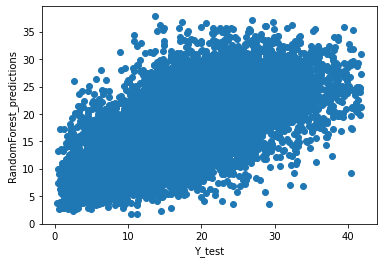

In [100]:
plt.scatter(Y_test, predictions_rfr)
plt.xlabel('Y_test')
plt.ylabel('RandomForest_predictions')

In [101]:
metricsProject(Y_train, Y_hat_rfr)

'Absolute error: 3.338078132837298.     Mean Squared Error: 19.446326385552467.     Root Squared Error: 4.409798905341656'

In [102]:
metricsProject(Y_test, predictions_rfr)

'Absolute error: 5.254651494509322.     Mean Squared Error: 44.73270243704956.     Root Squared Error: 6.688251074612074'

Comparing the metrics using the Y_train and Y_test data sets shows that the model is overfitting. It predicted well in the train data, while in the test data, the errors increased notably. Therefore, the hyperparameters will be tuned to get the best scenario.

In [103]:
#Getting the parameters of the random forest regressor
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [104]:
#Getting the lists of parameters to test with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 800, 1400, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 43, 76, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [105]:
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [106]:
# Fit the random search model
rfr_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 43, 76, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 800, 1400, 2000]},
                   random_state=42, verbose=2)

In [107]:
rfr_random.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=2000, random_state=42)

In [108]:
#Getting the predictions with X_test and X_train
predictions_rfr_random = rfr_random.predict(X_test)
Y_hat_rfr_random = rfr_random.predict(X_train)


Text(0, 0.5, 'RandomForest_tunned_predictions')

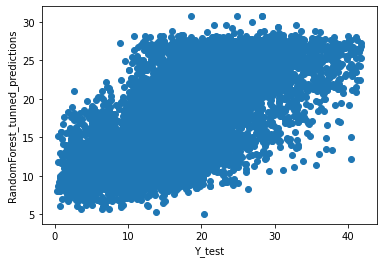

In [109]:
#Graph of results of predictions
plt.scatter(Y_test, predictions_rfr_random)
plt.xlabel('Y_test')
plt.ylabel('RandomForest_tunned_predictions')

In [110]:
#predictions with test data set
metricsProject(Y_test, predictions_rfr_random)

'Absolute error: 4.81151563064689.     Mean Squared Error: 36.87072595856508.     Root Squared Error: 6.072126971545068'

In [111]:
#predictions with training data set
metricsProject(Y_train, Y_hat_rfr_random)

'Absolute error: 4.599417728589608.     Mean Squared Error: 33.71957277539138.     Root Squared Error: 5.806855670273834'

Now, the model is no longer overfitting and the error of the test data set diminished

## Section 4: Results

### Model Evaluation and Validation
The results of the Linear Model Regression showed a higher Root Squared Error than the Random Forest tuned. 

In [112]:
print('Linear Model Regression Results:', metricsProject(Y_test, lm_predictions))

print('Random Forest Results: ', metricsProject(Y_test, predictions_rfr_random))


Linear Model Regression Results: Absolute error: 4.911328712901499.     Mean Squared Error: 38.65832155840111.     Root Squared Error: 6.217581648712071
Random Forest Results:  Absolute error: 4.81151563064689.     Mean Squared Error: 36.87072595856508.     Root Squared Error: 6.072126971545068


Therefore, the best model to use to predict the amount spent of the mimic data set of Starbucks is the RandomForestRegressor. However, the error continues being high relative to the mean of the amount spent

In [113]:
#Percentage of the amount spent
'The Mean Squared Error percentage of the mean of the amount spent is {calc}%'.format(calc = round(np.sqrt(metrics.mean_squared_error(Y_test, predictions_rfr_random))/df.amount.mean()*100, 2))

'The Mean Squared Error percentage of the mean of the amount spent is 34.64%'

In this case, it is suggested to add more variables while using a machine learning model. In this study, intending to compare results with the Linear model Regression, both models had the same independent variables. 

### Justification
In this study, the Random Forest Model with tunned hyperparameters performed better than the linear regression because it uses more parameters to optimize and have better estimates. However, the metrics between the two models do not show a big difference in performance. In this case, using the factors selected, the Random Forest Model could just have slightly lower errors than the first one. If the percentage of the Root Squared Error that improved is compared between both models, it will be noticed that it is not so significant.

In [114]:
#Percentage of improvement
'The percentage of improvement is {perc_ipr}%'.format(perc_ipr = round((np.sqrt(metrics.mean_squared_error(Y_test, lm_predictions))- np.sqrt(metrics.mean_squared_error(Y_test, predictions_rfr_random)))/np.sqrt(metrics.mean_squared_error(Y_test, lm_predictions))*100, 2))

'The percentage of improvement is 2.34%'

## Section 5: Conclusion
### Reflection
The aim of this report was predicting the amount spent on the mimic data set of Starbucks using two models and comparing their results. 
The cleansing process was done and some outliers were removed to enhance predictions. Also, null values were deleted due to the small percentage. 
The Linear Regression model was tested after solving the problem of multicollinearity. To accomplish the assumption of the linear regression VIF and Spearman correlation were used and the Normality assumption was checked graphically. In this respect, some variables at first set had to be taken out of the model. 
To compare this model with Random Forest, the final model specification of the linear regression was taken for testing; therefore, fewer independent variables were added than the set thought at first. Apart from that, the first results of the Random Forest model showed overfitting, so the parameters were tuned using the RandomSearchCV command.
The results of this last model showed a better performance; however, it was not so different from the linear regression model (The error just improved by 2.34%). Therefore, it could be said that linear regression predicts well when it follows the assumptions required; on the other hand, some variables had to be removed to obey the assumptions. 

### Improvement
It is recommended to add more variables as factors to the Random Forest Model. In this case, more of them were not taken into consideration due to obeying linear regression assumptions and comparing both models.